## Mono/Di-derm phenotype: phenotype prediction, feature selection, and data visualization

This notebook provides a pipeline for predicting the mono/Di-dermy phenotype and identifying genome footprints. 

We train and test XGBoost classifier on COG count tables, that are split into the test and train ones at a specified taxonomy level (i.e. all samples from a taxonomy group go to either train or test). The notebook can be run for one taxonomy level split. 

To identify genome footprints and the most important features (COGs) contributing to the phenotype prediction, we use three different feature selection ranking methods:

- calculating the mutual information between the feature and the target label vector,
- using the feature weights returned by the random forest model,
- calculating SHAP values using the pre-trained XGBoost model.

The predictions of those three methods are compared between each other at the end of the notebook. 

#### 1. Read the train and test datasets

First, we read the input files generated by *taxa_level_split.py*. The script generates 6 output files for the chosen [tax_level] of the train/test split, that are used as main inputs in this notebook. The files are the following:

- train_data_[tax_level]_tax_level : training count table,
- train_annot_[tax_level]_tax_level : training annotations,
- train_taxa_names_[tax_level]_tax_level : [tax_level] name of each training sample,

\+ 3 similar test tables. Those files should be stored in the corresponding directory for the phenotype.

In order to run the phenotype prediction pipeline in this notebook, the data directory with the input files, and [tax_level] of the train/test split should be specified below.

In [3]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from utils.utils import read_diderm_data, pca_run_and_plot, tsne_plot

TAX_LEVEL = "phylum" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_diderm"  # <-------- input data directory is here!!
RANDOM_SEED = 42
OUTPUT_DIRECTORY = f"../{DATA_DIRECTORY}/plots_{TAX_LEVEL}_tax_level"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = f"../{DATA_DIRECTORY}/input_data/train_taxa_names_{TAX_LEVEL}_tax_level"
X_val_train, y_label_train, X_column_names, taxa_group_names_train = read_diderm_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = f"../{DATA_DIRECTORY}/input_data/test_taxa_names_{TAX_LEVEL}_tax_level"
X_val_test, y_label_test, X_column_names, taxa_group_names_test = read_diderm_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

Next, we find the percentage of mono- and di-derms in the train and test datasets. We need to make sure that there is no huge data disbalance between the aerobs/anaerobs classes and between the train/test datasets.

In [4]:
num_mono_train = float(sum(y_label_train.cpu()))
num_di_train = float(len(y_label_train.cpu()) - num_mono_train)
print(f"Number of Monoderms in train = {num_mono_train}, which is {round(100*num_mono_train/(num_mono_train+num_di_train),2)} %")
print(f"Number of Diderms = {num_di_train}, which is {round(100*num_di_train/(num_mono_train+num_di_train),2)} %\n")

num_mono_test = float(sum(y_label_test.cpu()))
num_di_test = float(len(y_label_test.cpu()) - num_mono_test)
print(f"Number of Monoderms in test = {num_mono_test}, which is {round(100*num_mono_test/(num_mono_test+num_di_test),2)} %")
print(f"Number of Diderms = {num_di_test}, which is {round(100*num_di_test/(num_mono_test+num_di_test),2)} %")

Number of Monoderms in train = 253.0, which is 34.19 %
Number of Diderms = 487.0, which is 65.81 %

Number of Monoderms in test = 63.0, which is 33.87 %
Number of Diderms = 123.0, which is 66.13 %


#### 2. PCA and tSNE projections

In this section, we visualize all points from our datasets by projecting them into 2D PCA, and tSNE spaces. This projections give us insights on the structure of the datasets. One point = one sample/genome.

First, we color the projected samples with respect to their phenotype (mono/diderm).

In [5]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

Shape of the projected data = (740, 2)


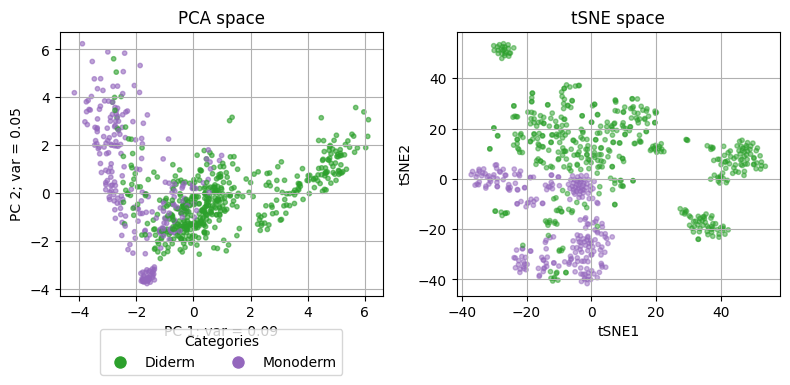

In [6]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = ["Diderm" if yi == 0 else "Monoderm" for yi in y_label_train]
legend = True
pca_run_and_plot(X_val_train.cpu(), n_compon, y_label_train.cpu(), category_names, colors, legend);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, y_label_train.cpu(), colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phenot.pdf", format="pdf")
plt.show()

Next, we color the points with respect to the chosen taxonomy level.

Shape of the projected data = (740, 2)


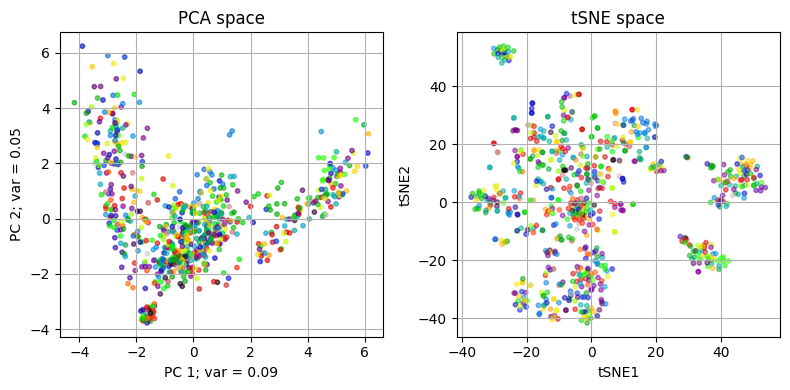

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# Put to True, if a legend is needed (it might be too longr for some taxonomy levels)
legend = False

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = ["Diderm" if yi == 0 else "Monoderm" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, label_encoder.fit_transform(taxa_group_names_train), taxa_group_names_train, None, legend);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, label_encoder.fit_transform(taxa_group_names_train), None);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phylogen.pdf", format="pdf")
plt.show()

#### 3. XGBoost training and feature selection

In this section we train XGBoost classifier for the mono/didermy phenotype prediction, and perform the feature selection analysisc based on three different methods.

First, we find the baseline (for all GOGs) test and cross-validation accuracy measures. As the accuracy measures, we use the following:

- accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$,
- precision = $\frac{TP}{TP+FP}$,
- recall = $\frac{TP}{TP+FN}$,
- F1 = $2 \frac{precision \times recall}{precision + recall}$,
- ROC_AUC is the area under the curve plotting True Positive Rate ($\frac{TP}{TP+FN}$) vs False Positive Rate  ($\frac{FP}{FP+TN}$).

In [8]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [9]:
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_val_train, y_label_train, X_val_test, y_label_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {cv_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


XGBoost baseline test accuracy (all features) = {'accuracy': 0.9932432432432432, 'precision': 0.9808389538689205, 'recall': 1.0, 'f1': 0.9902901529884132, 'roc_auc': 0.9986530612244898}
XGBoost cv_accuracy (all features) = {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}


Next, we perform feature selection. First, we rank all the features with respect to the chosen method (mutual information, random forest weigths, and SHAP) from the most to the least importan ones. Then we gradually add ranked features starting from the most important one, re-train the model and evaluate its performance. As the second test, we gradually remove features satrting from the least important ones, and evaluate the performance of the re-trained model again. The results are shown below.

As a baseline, we do this analysis for random feature ranking, i.e. we generate random feature order N times, and find the average accuracy and std across the runs for the added and removed features.

In [10]:
X_train_np = np.array(X_val_train.cpu())
X_train_transposed = X_train_np.T

In [11]:
from feature_selection.feature_selection_utils import random_feat_removal_curves

num_runs = 4
feat_step = 10

feat_removal = False
cv_accur_arr_all_runs_mn, cv_accur_arr_all_runs_std, test_accur_arr_all_runs_mn, test_accur_arr_all_runs_std, num_feat = random_feat_removal_curves(X_val_train, X_val_test, y_label_train, y_label_test, num_runs, feat_step, DEVICE, feat_removal);    

In [12]:
feat_removal = True
cv_accur_arr_all_runs_mn_rem, cv_accur_arr_all_runs_std_rem, test_accur_arr_all_runs_mn_rem, test_accur_arr_all_runs_std_rem, num_feat = random_feat_removal_curves(X_val_train, X_val_test, y_label_train, y_label_test, num_runs, feat_step, DEVICE, feat_removal);

#### 3.1 Feature selection with Mutual Information

In this section, we rank the features (COGs) using the mutual information. The mutual information quantifies "the amount of information one random variable contains about another".

We calculate the mutual information between each feature and the target label vector with phenotypes, and rank all the features from the largest to the smallest value.

In [13]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, RANDOM_SEED)

In [14]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0795', 'COG0763', 'COG0767', 'COG1127', 'COG1519', 'COG1663', 'COG1212', 'COG0854', 'COG0774', 'COG4783']


Using the ranked features, we re-generate the PCA and tSNE projections using the top N features only. It's expected that the separation between diffetent classes become more prominent.

Shape of the projected data = (740, 2)


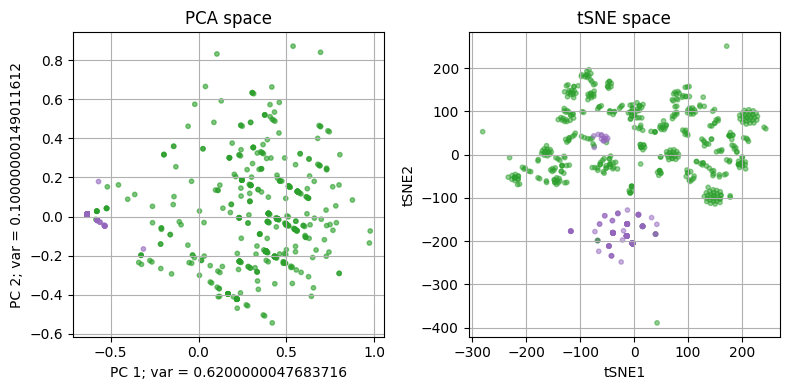

In [15]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_mi_feat.pdf", format="pdf")
plt.show()


In [16]:
feat_step = 10
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [17]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [18]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': 0.9459459459459459, 'precision': 0.8677598798169924, 'recall': 1.0, 'f1': 0.9281758208639767, 'roc_auc': 0.9588365243004418}
{'accuracy': 0.9301075268817204, 'precision': 0.8289473684210527, 'recall': 1.0, 'f1': 0.9064748201438849, 'roc_auc': 0.9471544715447154}


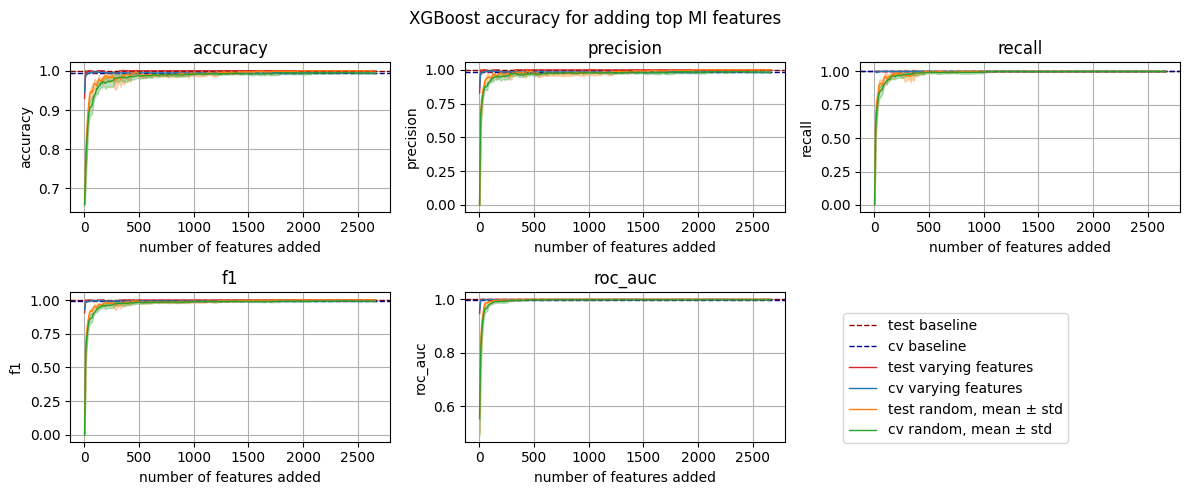

In [19]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf")   

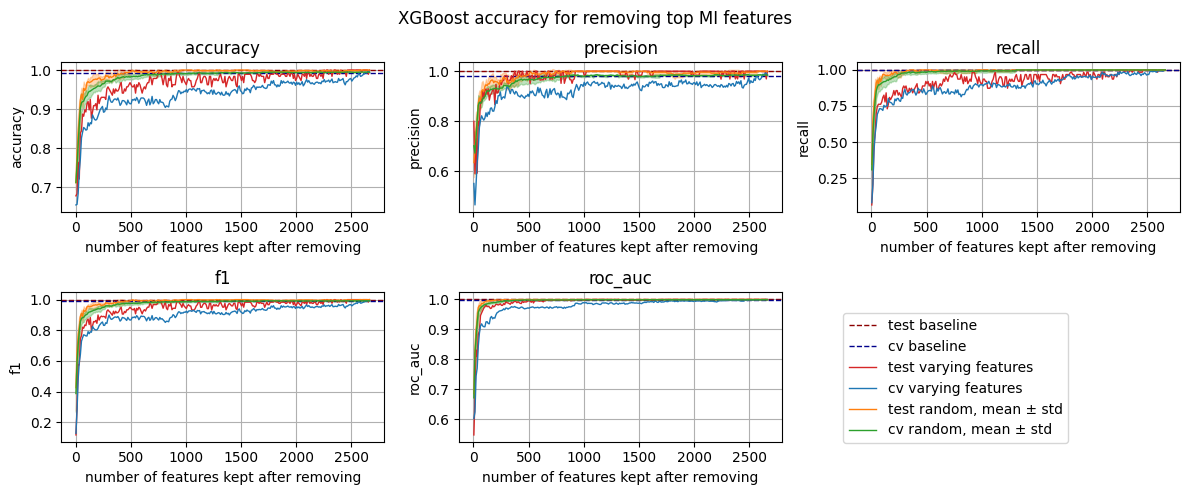

In [20]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf")  

#### 3.2 Feature selection with Random Forest

In this section, we rank the features (COGs) using random forest model. During training, the model assigns weights to each feature with respect to their importamce to the prediction task. We train random forest on the train dataset, find the weights, and rank the features with respect to the values of the weights.

The rest of the analysis is the same as the one for the mutual information.

In [21]:
from feature_selection.feature_selection_utils import random_forest_features
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, RANDOM_SEED)

Original feature count: 2665, Selected feature count: 309


In [22]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG0767', 'COG0763', 'COG0795', 'COG1127', 'COG1519', 'COG1212', 'COG4783', 'COG1663', 'COG1995', 'COG0774']


In [23]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Shape of the projected data = (740, 2)


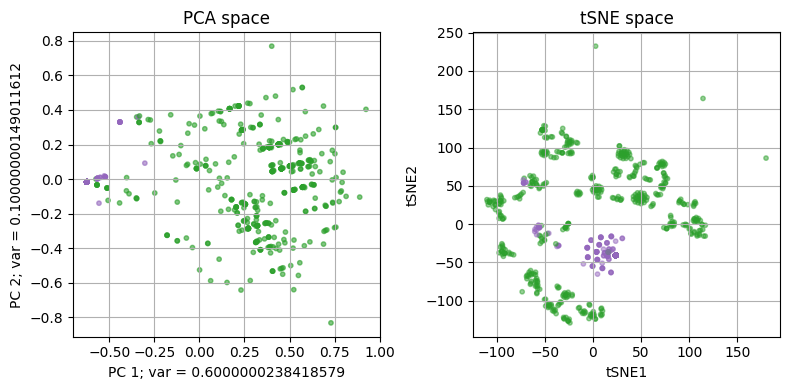

In [24]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [25]:
feat_step = 10
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [26]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': 0.9175675675675675, 'precision': 0.8331846448240146, 'recall': 0.952470588235294, 'f1': 0.8881170910374451, 'roc_auc': 0.9403077560921276}
{'accuracy': 0.9408602150537635, 'precision': 0.8611111111111112, 'recall': 0.9841269841269841, 'f1': 0.9185185185185185, 'roc_auc': 0.9587043489482514}


In [27]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

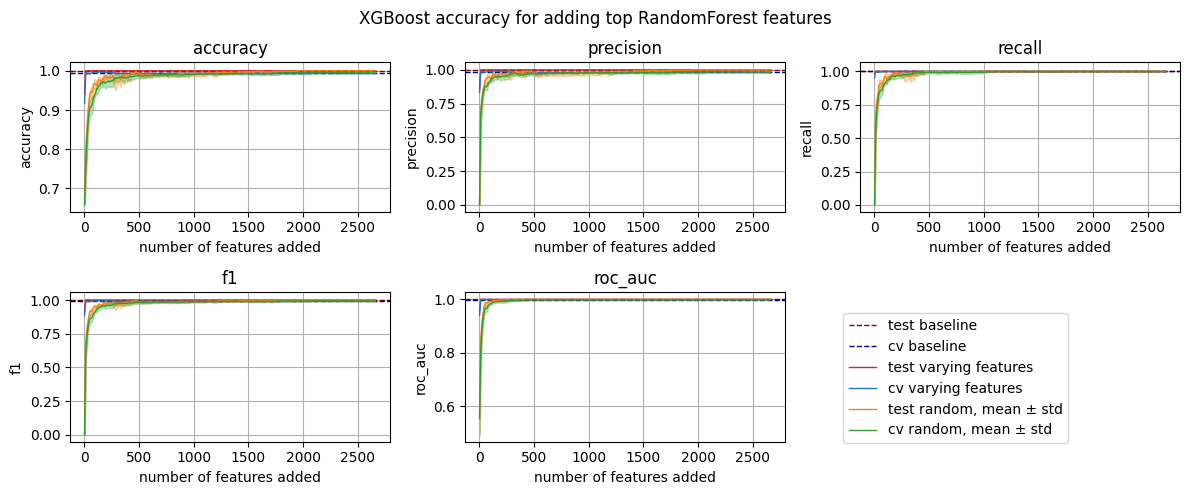

In [28]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_rand_for_feat_add.pdf", format="pdf") 

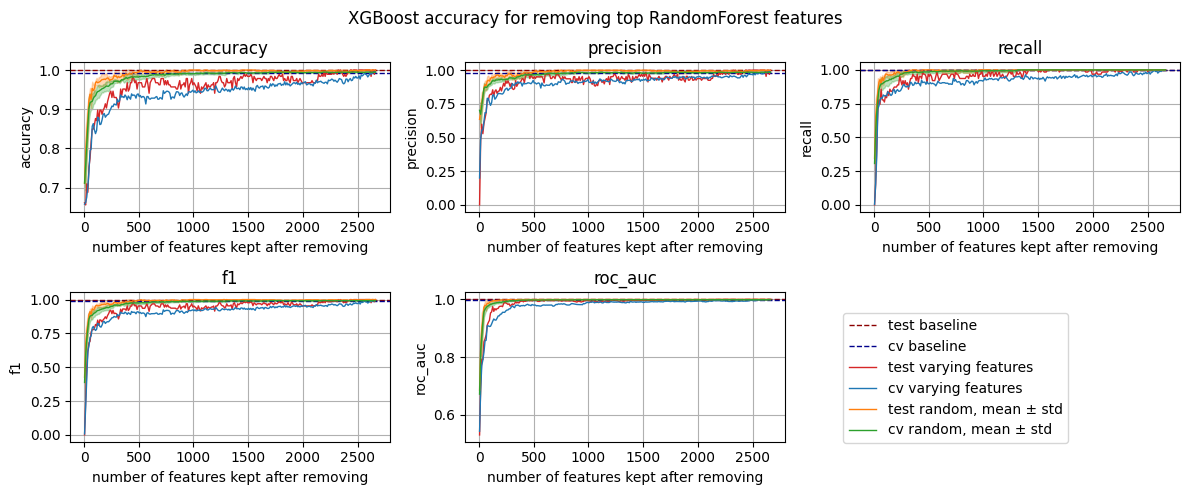

In [29]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_rand_for_feat_remov.pdf", format="pdf")  

#### 3.3 Feature selection with SHAP values

In this section, we rank the features (COGs) with respect to their SHAP values. SHAP value for a feature is calculated by re-training a model without this feature and comparing the accuracy to the original one on the full feature set. We calculate SHAP values for all features, and rank them from the largest to the smallest.

The rest of the analysis is the same as the ones in the two previous cases.

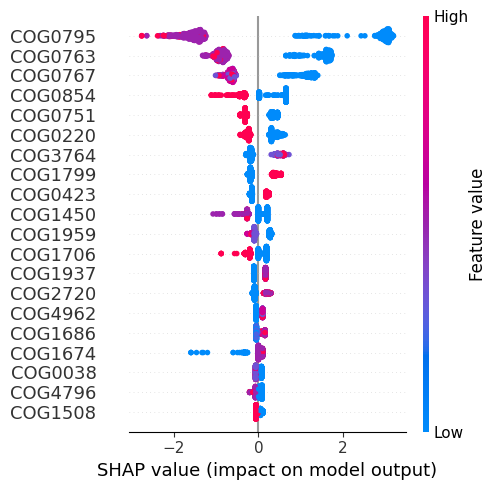

In [30]:
from feature_selection.feature_selection_utils import shap_features

device = 'cpu'
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, device) 

In [31]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0795', 'COG0763', 'COG0767', 'COG0854', 'COG0751', 'COG0220', 'COG3764', 'COG1799', 'COG0423', 'COG1450']


Shape of the projected data = (740, 2)


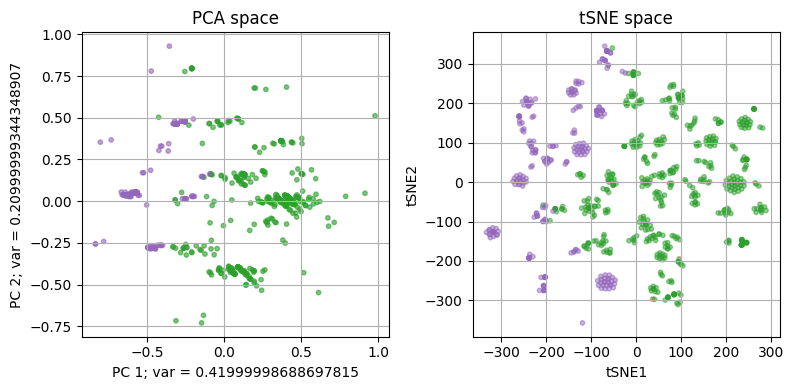

In [32]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [33]:
feat_step = 10
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

In [34]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

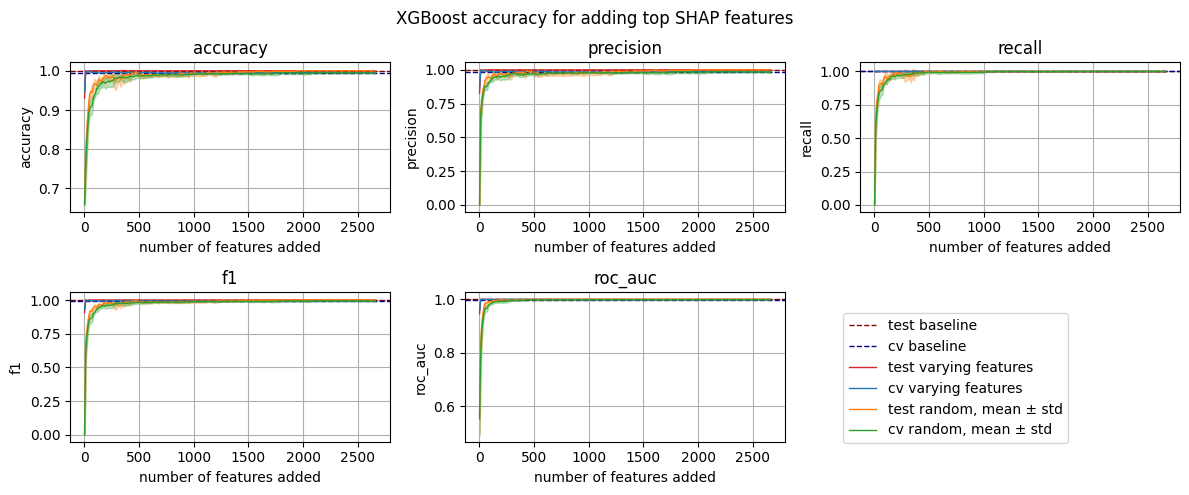

In [35]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_add.pdf", format="pdf") 

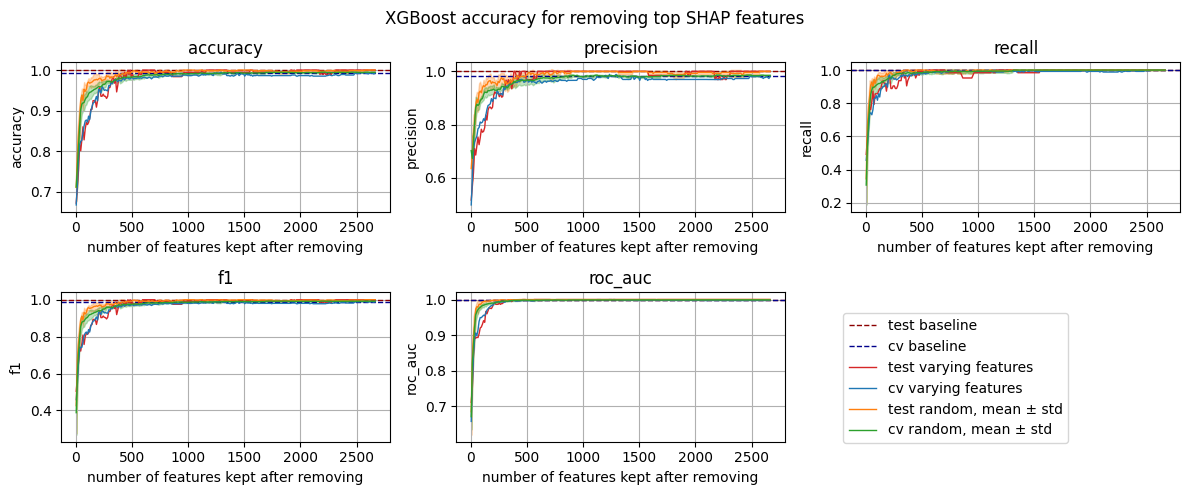

In [36]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_remov.pdf", format="pdf")  

#### 4. Feature comparison

In this section, we compare top of the most important features predicted with mutual information, random forest, and SHAP values between each other. The lists of the top N features should overlap..

In [37]:
import pandas as pd
from feature_selection.feature_selection_utils import make_cog_descr

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)
make_cog_descr(df)

,MI,RandomForest,SHAP
0,COG0795: Lipopolysaccharide export LptBFGC sys...,COG0767: Permease subunit MlaE of the ABC-type...,COG0795: Lipopolysaccharide export LptBFGC sys...
1,COG0763: Lipid A disaccharide synthetase,COG0763: Lipid A disaccharide synthetase,COG0763: Lipid A disaccharide synthetase
2,COG0767: Permease subunit MlaE of the ABC-type...,COG0795: Lipopolysaccharide export LptBFGC sys...,COG0767: Permease subunit MlaE of the ABC-type...
3,COG1127: ATPase subunit MlaF of the ABC-type i...,COG1127: ATPase subunit MlaF of the ABC-type i...,COG0854: Pyridoxine 5'-phosphate synthase PdxJ
4,COG1519: 3-deoxy-D-manno-octulosonic-acid tran...,COG1519: 3-deoxy-D-manno-octulosonic-acid tran...,"COG0751: Glycyl-tRNA synthetase, beta subunit"
5,COG1663: Tetraacyldisaccharide-1-P 4'-kinase (...,COG1212: CMP-2-keto-3-deoxyoctulosonic acid sy...,COG0220: tRNA G46 N7-methylase TrmB
6,COG1212: CMP-2-keto-3-deoxyoctulosonic acid sy...,COG4783: Periplasmic chaperone/metalloprotease...,COG3764: Sortase (surface protein transpeptidase)
7,COG0854: Pyridoxine 5'-phosphate synthase PdxJ,COG1663: Tetraacyldisaccharide-1-P 4'-kinase (...,"COG1799: Cell division protein SepF/YlmF, inte..."
8,COG0774: UDP-3-O-acyl-N-acetylglucosamine deac...,COG1995: 4-hydroxy-L-threonine phosphate dehyd...,"COG0423: Glycyl-tRNA synthetase, class II"
9,COG4783: Periplasmic chaperone/metalloprotease...,COG0774: UDP-3-O-acyl-N-acetylglucosamine deac...,COG1450: Type II/type III secretion systems/ty...


Also, we construct a correlation matrix wetween the top features returned by each method.

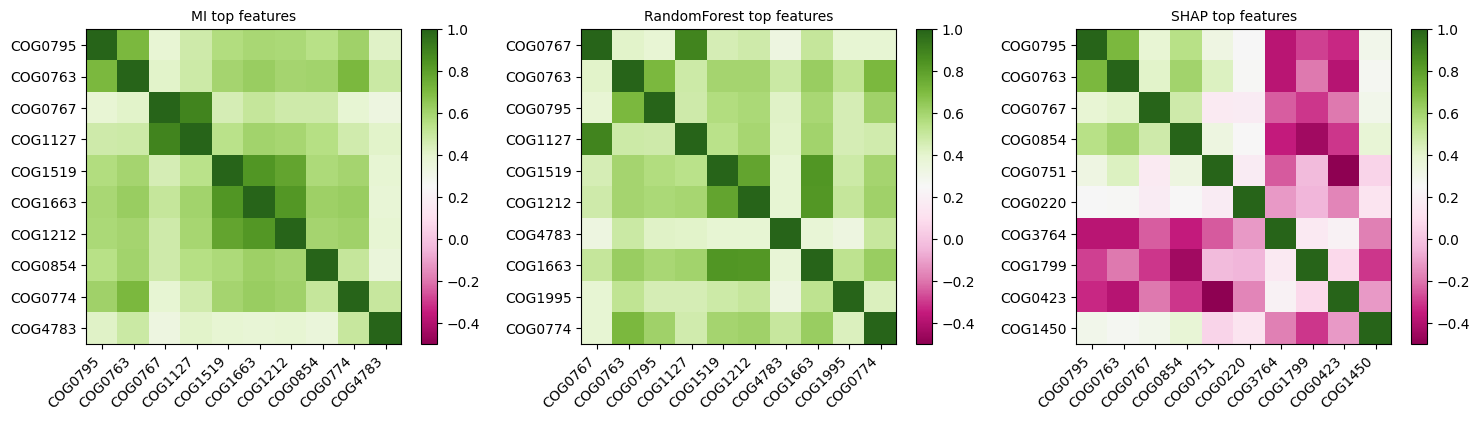

In [38]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")
plt.show()


#### 5. Expression level of the top features

In this section, we visualize the expression level of a feature in the train samples (with respect to the feature counts). Comparison of this plot to the PCA/tSNE projections with points colored with respect to their phenotype can give insights on the feature "signal distribution" across the samples and the different phenotype groups.

In [41]:
feature_name = 'COG0763'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_val_train[:, idx]
feature_expression = feature_expression.cpu()

Shape of the projected data = (740, 2)


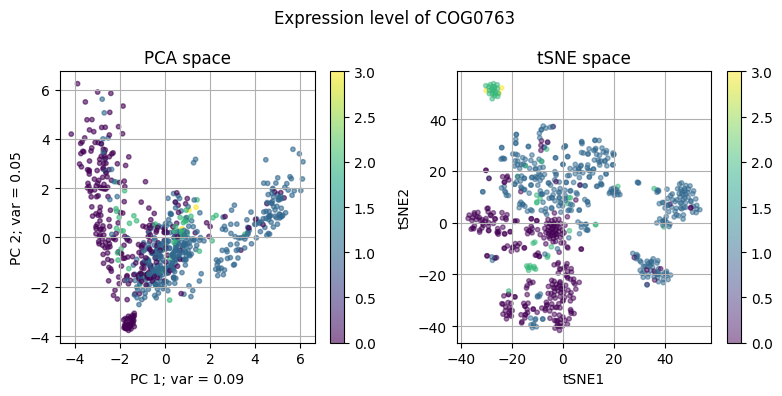

In [42]:
from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
category_names = ["anaerobe" if yi == 0 else "aerobe" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}//pca_tsne_{feature_name}_feat_express_lev.pdf", format="pdf")
plt.show()